In [6]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import cmdstanpy ## import stan interface for Python
import os
import seaborn as sns
import pandas as pd
from importlib import reload 
import sys
sys.path.append("..")
import matplotlib.gridspec as gridspec

import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from statannotations.Annotator import Annotator
from itertools import product

from scipy.optimize import curve_fit
from scipy.special import logit


tex_fonts = {
    # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "Helvetica",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.grid": True,
    'grid.color': '#DDDDDD',
    'grid.linestyle': '-',
    'grid.linewidth': 0.3,
    "lines.markersize":4,
    "lines.markeredgewidth":1,
    'axes.axisbelow':True,
    'pdf.fonttype':42,
    'axes.linewidth':0.5,
    'xtick.major.width':0.5,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3,

    'ytick.major.pad':0.2,
    "xtick.major.size":3,
    "ytick.major.size":3,
}

plt.rcParams.update(tex_fonts)

if os.name == "nt": ## adds compiler to path in Windows
    cmdstanpy.utils.cxx_toolchain_path() 
    

np.random.seed(2101)


ratio= 2/(1+np.sqrt(5))

width = 520.344

kwags = {"wspace":0.2}

my_pal = {"4cm": "g", 
          "4em": "m", 
          "Donor":"#a4e0ef", 
          "Host":"#ff7f0e",
         "WT":"#02feff",
         "Young CHIM":"#008080",
         "Old CHIM":"None"}

my_marks = {"Donor": "o", 
           "Host": "X",
         "WT":"o",
         "Young CHIM":"o", #"P",
         "Old CHIM":"o"}

scatterkwags = {"palette": my_pal,
                  "markers":my_marks,
                  'edgecolor':'k',

                
}

def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

df = pd.read_csv('/home/elise/Code/BRDU/Elisehasbeenusing_dataUCL.csv',index_col='index')
df['age_cat']=np.where(df.age < 114, 'WT', np.where((df.age >= 114) & (df.age < 180), 'Young CHIM', 'Old CHIM'))

df['ADH'] = df['ADH'].replace('donor','Donor')
df['ADH'] = df['ADH'].replace('host','Host')

typei='burst'

In [7]:
# def myMAP_CI(datad, datah):


#     arrayedd = datad.to_numpy()
#     nparam_densityd = sts.kde.gaussian_kde(arrayedd)
#     xd = np.linspace(np.min(arrayedd), np.max(arrayedd), 2000)
#     nparam_densityd = nparam_densityd(xd)

#     lA_calcd, uA_calcd = np.percentile(datad, q=[5, 95])
    
#     arrayedh = datah.to_numpy()
#     nparam_densityh = sts.kde.gaussian_kde(arrayedh)
#     xh = np.linspace(np.min(arrayedh), np.max(arrayedh), 2000)
#     nparam_densityh = nparam_densityh(xh)

#     lA_calch, uA_calch = np.percentile(datah, q=[5, 95])
    
    
#     return [xd[np.argsort(nparam_densityd)[-1]],  lA_calcd, uA_calcd, xh[np.argsort(nparam_densityh)[-1]],  lA_calch, uA_calch] 


def myMAP_CI(datad, datah):


    arrayedd = datad.to_numpy()
    mediand = np.median(arrayedd)

    lA_calcd, uA_calcd = np.percentile(datad, q=[5, 95])
    
    arrayedh = datah.to_numpy()
    medianh = np.median(arrayedh)


    lA_calch, uA_calch = np.percentile(datah, q=[5, 95])
    
    
    return [mediand,  lA_calcd, uA_calcd, medianh,  lA_calch, uA_calch] 


def myMAP(data):

    arrayed = data.to_numpy()
    nparam_density = sts.kde.gaussian_kde(arrayed)
    x = np.linspace(np.min(arrayed), np.max(arrayed), 2000)
    nparam_density = nparam_density(x)

    return x[np.argsort(nparam_density)[-1]]


from scipy.stats import mannwhitneyu
def ustat(pairs):
    x = 'ADH'
    pvalues = []
    for pair in pairs:
        df1 = df[(df['age_cat'] == pair[0][0])]
        data1 = df1.groupby(x)[y].get_group(pair[0][1])
        data2 = df1.groupby(x)[y].get_group(pair[1][1])
        stat1, p1 = mannwhitneyu(data1, data2)
        stat2, p2 = mannwhitneyu(data2, data1)
        stat = min(stat1,stat2)
    #         print((data1))
        calcp = stat/(len(data1)*len(data2))
        print("Mann Whitney Ustat calculated p:",
              pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(calcp)
    print("pvalues:", pvalues)
    
    return pvalues



In [8]:

#Initialization for equilibrium and amount of ODEs
numofki67int = 0
numofbrduint = 0
switch = (numofbrduint+2)*(numofki67int+2)
y0_est = 1000*np.ones((numofki67int+2)*(numofbrduint+2)*2)
time_index_equilibrium = np.linspace(10000/1, 10000, 1)


# data_tom = pd.read_excel(r'C:\Users\funny\Documents\GitHub\BRDU\CD4 Cre pulse chase data table 301023.xlsx',sheet_name = 'LN_surface',index_col='MouseID')
data_tom = pd.read_excel('/home/elise/Dropbox/NyLon/CD4cre pulse-chase/Old data versions/CD4 Cre pulse chase data table 301023.xlsx',sheet_name = 'LN_surface',index_col='MouseID')
data_tom = data_tom[['Days_post_treatment','LN_CASYgate','LN_4Naive.mT+','LN_4Naive.mT-','LN_4EM.mT+','LN_4EM.mT-','LN_4CM.mT+','LN_4CM.mT-']]
data_tom = data_tom.loc[(data_tom['Days_post_treatment']>7)]
data_tom = data_tom[data_tom.index.str.contains("BPS1")]
data_tom = data_tom.sort_values(by=['Days_post_treatment'])
# data_tom = data_tom.reset_index(drop=True)

# data_ki67 = pd.read_excel(r'C:\Users\funny\Documents\GitHub\BRDU\CD4 Cre pulse chase data table 301023.xlsx',sheet_name = 'LN_intracellular_Ki67',index_col='MouseID')
data_ki67 = pd.read_excel('/home/elise/Dropbox/NyLon/CD4cre pulse-chase/Old data versions/CD4 Cre pulse chase data table 301023.xlsx',sheet_name = 'LN_intracellular_Ki67',index_col='MouseID')
data_ki67 = data_ki67[['Days_post_treatment','LN_4Naive.mT+','LN_4Naive.mT-','LN_4EM.mT+','LN_4EM.mT-','LN_4CM.mT+','LN_4CM.mT-']]
data_ki67 = data_ki67.loc[(data_ki67['Days_post_treatment']>7)]
data_ki67 = data_ki67[data_ki67.index.str.contains("BPS1")]
data_ki67 = data_ki67.sort_values(by=['Days_post_treatment'])
# data_ki67 = data_ki67.reset_index(drop=True)


# data_m = pd.read_excel(r'C:\Users\funny\Documents\GitHub\BRDU\CD4 Cre pulse chase data table 301023.xlsx',sheet_name = 'Metadata',index_col='MouseID')
data_m = pd.read_excel('/home/elise/Dropbox/NyLon/CD4cre pulse-chase/Old data versions/CD4 Cre pulse chase data table 301023.xlsx',sheet_name = 'Metadata',index_col='MouseID')
data_m = data_m[['Days_post_treatment','LN_Cellcounter','Age_at_SK1']]
data_m = data_m.loc[(data_m['Days_post_treatment']>7)&(data_m['Days_post_treatment']!=(18))&(data_m['Days_post_treatment']!=(79))&(data_m['Days_post_treatment']!=(88))]
data_m = data_m[data_m.index.str.contains("BPS1")]
data_m = data_m.sort_values(by=['Days_post_treatment'])
# data_m = data_m.reset_index(drop=True)

for name in ['LN_4Naive.mT+','LN_4Naive.mT-','LN_4EM.mT+','LN_4EM.mT-','LN_4CM.mT+','LN_4CM.mT-']: #
    data_tom[name+'norm'] = data_tom[name]*data_m['LN_Cellcounter']/data_tom['LN_CASYgate']
    data_tom[name+'ki67'] = data_tom[name+'norm']*data_ki67[name]/100

data_tom['Age_at_SK1'] = data_m['Age_at_SK1']


time_index = data_tom['Days_post_treatment'].values.tolist()

naivetomhi = data_tom['LN_4Naive.mT+norm'].values.tolist()
naivetomlo =  data_tom['LN_4Naive.mT-norm'].values.tolist()
naivecounts_log = np.array(naivetomlo)+np.array(naivetomhi)
naivetomlo_c = naivetomlo
naivetomhi_c = naivetomhi
naivetomlo_f = np.array(naivetomlo)/(naivecounts_log)
naivetomhi_f = np.array(naivetomhi)/(naivecounts_log)
naivecounts_t0 = naivetomhi[0]+naivetomlo[0]

emtomhi = data_tom['LN_4EM.mT+norm'].values.tolist()
emtomlo =  data_tom['LN_4EM.mT-norm'].values.tolist()
emtomhi_nn = data_tom['LN_4EM.mT+'].values.tolist()
emtomlo_nn =  data_tom['LN_4EM.mT-'].values.tolist()
emcounts_log = np.array(emtomlo)+np.array(emtomhi)
emtomlo_c = emtomlo
emtomhi_c = emtomhi
emtomlo_f = np.array(emtomlo)/(emcounts_log)
emtomhi_f = np.array(emtomhi)/(emcounts_log)
emtomloki67_c = data_tom['LN_4EM.mT-ki67'] 
emtomhiki67_c = data_tom['LN_4EM.mT+ki67'] 
emtomloki67_f = data_tom['LN_4EM.mT-ki67']/data_tom['LN_4EM.mT-norm'] 
emtomhiki67_f = data_tom['LN_4EM.mT+ki67']/data_tom['LN_4EM.mT+norm']
emcounts_t0 = emtomhi[0]+emtomlo[0]
emtomhi_t0 = np.mean(emtomhi[0:3])
emtomlo_t0 = np.mean(emtomlo[0:3])
emtomhin_t0 = np.mean(emtomhi_nn[0:3])
emtomlon_t0 = np.mean(emtomlo_nn[0:3])
emtomhiki67_t0 = np.mean(emtomhiki67_f[0:3])
emtomloki67_t0 = np.mean(emtomloki67_f[0:3])

cmtomhi =data_tom['LN_4CM.mT+norm'].values.tolist()
cmtomlo =data_tom['LN_4CM.mT-norm'].values.tolist()
cmtomhi_nn =data_tom['LN_4CM.mT+'].values.tolist()
cmtomlo_nn =data_tom['LN_4CM.mT-'].values.tolist()
cmcounts_log = np.array(cmtomlo)+np.array(cmtomhi)
cmtomlo_c = cmtomlo
cmtomhi_c = cmtomhi
cmtomlo_f = np.array(cmtomlo)/(cmcounts_log)
cmtomhi_f = np.array(cmtomhi)/(cmcounts_log)
cmtomloki67_c = data_tom['LN_4CM.mT-ki67'] 
cmtomhiki67_c = data_tom['LN_4CM.mT+ki67'] 
cmtomloki67_f = data_tom['LN_4CM.mT-ki67']/data_tom['LN_4CM.mT-norm'] 
cmtomhiki67_f = data_tom['LN_4CM.mT+ki67']/data_tom['LN_4CM.mT+norm']
cmcounts_t0 = cmtomhi[0]+cmtomlo[0]
cmtomhi_t0 = np.mean(cmtomhi[0:3])
cmtomlo_t0 = np.mean(cmtomlo[0:3])
cmtomhin_t0 = np.mean(cmtomhi_nn[0:3])
cmtomlon_t0 = np.mean(cmtomlo_nn[0:3])
cmtomhiki67_t0 = np.mean(cmtomhiki67_f[0:3])
cmtomloki67_t0 = np.mean(cmtomloki67_f[0:3])


In [9]:
data_tom.to_csv("fig7.csv")

In [4]:

from itertools import product

parnames_L = ["alpha_A","alpha_B","delta_A","delta_B","beta","mu","eff","gamma","Source"] 

parnames_B = ["alpha_A","alpha_B","delta_A","delta_B","beta","mu","eff","fs","Source"] 

pardf = pd.DataFrame()

ADHc = ['all','donor']
populationc = ['em', 'cm']


for adh_i, pop_i in product(ADHc,populationc):

    location = '/opt/mesh/tiree/elise/samples_1/youngmice_r19/stan-cache-4'+pop_i+adh_i+'_1/'
    sys.path.insert(1, location)
    import paras
    reload(paras)
    
    fl = []
    fb = []
    fs = [] 
    
    for f_name in os.listdir(location):
        if f_name.endswith('.csv')&f_name.startswith('branched'):
            print(f_name)
            fb.append(paras.filelocation+f_name)
        elif f_name.endswith('.csv')&f_name.startswith('linear'):
            print(f_name)
            fl.append(paras.filelocation+f_name)
        elif f_name.endswith('.csv')&f_name.startswith('burst'):
            print(f_name)
            fs.append(paras.filelocation+f_name)

    sam_fb = cmdstanpy.from_csv(fb)
    sam_fl = cmdstanpy.from_csv(fl)
    sam_fs = cmdstanpy.from_csv(fs)


    parests_flvl = [sam_fl.stan_variable(pn) for pn in parnames_L]
    parests_fsvl = [sam_fs.stan_variable(pn) for pn in parnames_L]
    parests_fbvl = [sam_fb.stan_variable(pn) for pn in parnames_B]

    k_hat_fl =  sam_fl.stan_variable("k_hat")
    k_hat_fb =  sam_fb.stan_variable("k_hat")
    k_hat_fs =  sam_fs.stan_variable("k_hat")
    
    pardf_lvl=pd.DataFrame(np.transpose(parests_flvl), columns = parnames_L)
    pardf_lvl['type']='linear'
    pardf_lvl['population']=paras.populationc
    pardf_lvl['doh']=paras.ADHc
    pardf_lvl['popdoh']=paras.populationc+paras.ADHc
    pardf_lvl["fs"]=1
    pardf_lvl['FastFraction']=np.mean(np.sum(k_hat_fl[:,:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fl[:,:,:],axis=2), axis=1)

    pardf_svl=pd.DataFrame(np.transpose(parests_fsvl), columns = parnames_L)
    pardf_svl['type']='burst'
    pardf_svl['population']=paras.populationc
    pardf_svl['doh']=paras.ADHc
    pardf_svl['popdoh']=paras.populationc+paras.ADHc
    pardf_svl["fs"]=1
    pardf_svl['FastFraction']=np.mean(np.sum(k_hat_fs[:,:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fs[:,:,:],axis=2), axis=1)

    pardf_bvl=pd.DataFrame(np.transpose(parests_fbvl), columns = parnames_B)
    pardf_bvl['type']='branched'
    pardf_bvl['population']=paras.populationc
    pardf_bvl['doh']=paras.ADHc
    pardf_bvl['popdoh']=paras.populationc+paras.ADHc
    pardf_bvl['FastFraction']=np.mean(np.sum(k_hat_fb[:,:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fb[:,:,:],axis=2), axis=1)
    pardf_bvl["gamma"]=0
    
    pardf = pd.concat([pardf,pardf_lvl, pardf_bvl,pardf_svl])



#specific popultation

df_paraslice = pardf[(pardf['population'] =='4em')&(pardf['doh'] =='all')]


alpha_A_em = (df_paraslice[df_paraslice['type'] == typei].alpha_A) #A and B cells should have different rate!
delta_A_em = (df_paraslice[df_paraslice['type'] == typei].delta_A)
alpha_B_em = (df_paraslice[df_paraslice['type'] == typei].alpha_B) #A and B cells should have different rate!
delta_B_em = (df_paraslice[df_paraslice['type'] == typei].delta_B)

gamma_em = (df_paraslice[df_paraslice['type'] == typei].gamma)
fs_em = np.ones(len(alpha_A_em))
fastFraction_em = (df_paraslice[df_paraslice['type'] == typei].FastFraction)

SourceL = (df_paraslice[df_paraslice['type'] == typei].Source)

beta = (df_paraslice[df_paraslice['type'] == typei].beta)

G_em = (delta_A_em- alpha_A_em)*(df_paraslice[df_paraslice['type'] == typei].FastFraction)+(delta_B_em- alpha_B_em)*(1-(df_paraslice[df_paraslice['type'] == typei].FastFraction))

alpha_em = (alpha_A_em)*(df_paraslice[df_paraslice['type'] == typei].FastFraction)+(alpha_B_em)*(1-(df_paraslice[df_paraslice['type'] == typei].FastFraction))
delta_em = (delta_A_em)*(df_paraslice[df_paraslice['type'] == typei].FastFraction)+(delta_B_em)*(1-(df_paraslice[df_paraslice['type'] == typei].FastFraction))
Source_em = SourceL


#specific popultation

df_paraslice = pardf[(pardf['population'] =='4cm')&(pardf['doh'] =='all')]

alpha_A_cm = (df_paraslice[df_paraslice['type'] == typei].alpha_A) #A and B cells should have different rate!
delta_A_cm = (df_paraslice[df_paraslice['type'] == typei].delta_A)
alpha_B_cm = (df_paraslice[df_paraslice['type'] == typei].alpha_B) #A and B cells should have different rate!
delta_B_cm = (df_paraslice[df_paraslice['type'] == typei].delta_B)

gamma_cm = (df_paraslice[df_paraslice['type'] == typei].gamma)
fs_cm = np.ones(len(alpha_A_cm))
fastFraction_cm = (df_paraslice[df_paraslice['type'] == typei].FastFraction)
SourceL = (df_paraslice[df_paraslice['type'] == typei].Source)


alpha_cm = (alpha_A_cm)*(df_paraslice[df_paraslice['type'] == typei].FastFraction)+(alpha_B_cm)*(1-(df_paraslice[df_paraslice['type'] == typei].FastFraction))
delta_cm = (delta_A_cm)*(df_paraslice[df_paraslice['type'] == typei].FastFraction)+(delta_B_cm)*(1-(df_paraslice[df_paraslice['type'] == typei].FastFraction))
G_cm = (delta_A_cm- alpha_A_cm)*(df_paraslice[df_paraslice['type'] == typei].FastFraction)+(delta_B_cm- alpha_B_cm)*(1-(df_paraslice[df_paraslice['type'] == typei].FastFraction))
Source_cm = SourceL



branched-20240418181456_5.csv
linear-20240418181425_1.csv
linear-20240418181425_3.csv
branched-20240418181456_4.csv
burst-20240418181456_3.csv
burst-20240418181456_5.csv
burst-20240418181456_2.csv
linear-20240418181425_2.csv
branched-20240418181456_1.csv
linear-20240418181425_5.csv
branched-20240418181456_2.csv
burst-20240418181456_4.csv
burst-20240418181456_1.csv
branched-20240418181456_3.csv
linear-20240418181425_4.csv
branched-20240418181425_4.csv
linear-20240418181355_2.csv
branched-20240418181425_5.csv
linear-20240418181355_5.csv
branched-20240418181425_1.csv
branched-20240418181425_3.csv
burst-20240418181425_2.csv
linear-20240418181355_4.csv
burst-20240418181425_1.csv
burst-20240418181425_4.csv
linear-20240418181355_1.csv
branched-20240418181425_2.csv
linear-20240418181355_3.csv
burst-20240418181425_3.csv
burst-20240418181425_5.csv
linear-20240418181325_5.csv
linear-20240418181325_1.csv
branched-20240418181355_4.csv
linear-20240418181325_4.csv
burst-20240418181355_2.csv
burst-202

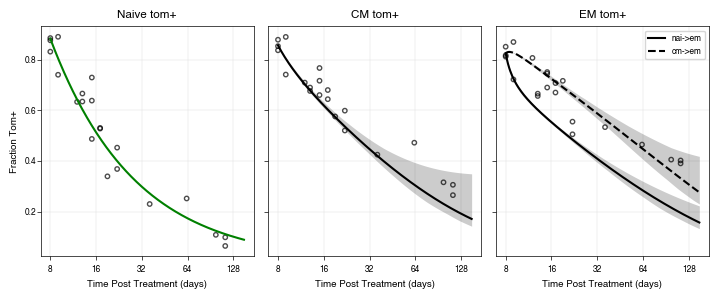

In [5]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(1,3, figsize=(7.2,3),tight_layout=True, sharey=True, sharex=True)


def func(x, a,b):
    return  (a*(np.power(x,-b)))

def logfunc(x, a,b):
    return  logit(a*(np.power(x,-b)))

popt, pcov = curve_fit(logfunc,time_index, logit(naivetomhi_f))


ax[0].scatter(time_index, (naivetomhi_f), color='none', edgecolor='k',s=10,alpha=0.7)

ax[0].plot(np.linspace(8,150,1000), (func(pd.Series(np.linspace(8,150,1000)), *popt)), 'g-')#,
          #label='fit1: a=%5.3f,b=%5.3f,' % tuple(popt))


ax[0].set_ylabel('Fraction Tom+')
ax[0].set_xlabel('Time Post Treatment (days)')
ax[0].set_title('Naive tom+')
ax[0].set_xscale('log', base=2)
ax[0].xaxis.set_major_formatter(mticker.ScalarFormatter())



#%% ki67 tom+ emcm  fast slow generating changes to em source

from scipy.integrate import solve_ivp
from random import choice, randint 
def vd_ode(t, y, popt,alpha_A_cm,delta_A_cm,alpha_B_cm,delta_B_cm, Source_cm, gamma_cm, fs_cm, alpha_A_em,delta_A_em, alpha_B_em,delta_B_em, Source_em, gamma_em, fs_em,beta,numofki67int,prec):

    # Order
    #CM
   
    numki67comp = numofki67int+1
    switch1 = (2)*(numofki67int+2)
    
    exp_decay_value=func(t+4,*popt)
    #cm_frac = CM_tomp/(CM_tomp+CM_tomn)
    
    
    if prec == 'nai':
        cm_frac=exp_decay_value
    elif prec == 'zero':
        cm_frac =1
    elif prec =='50':
        cm_frac=0.5
    else:
        cm_frac = sum(y[0:2*switch1:2])/sum(y[0:2*switch1])
        
    dy = np.zeros(switch1*4)
    
    
    # CM Fast tom+- Ki67+-int
    dy[0] = Source_cm*(exp_decay_value)*fs_cm - (delta_A_cm+numki67comp*beta+alpha_A_cm+gamma_cm)*y[0] + 2*alpha_A_cm*sum(y[0:(switch1):2])

    dy[1] = Source_cm*(1-exp_decay_value)*fs_cm -(delta_A_cm+alpha_A_cm+numki67comp*beta+gamma_cm)*y[1] + 2*alpha_A_cm*sum(y[1:(switch1):2])
        
    for i in range(numofki67int-1):
        for j in range(1):
            dy[(2)*(1+i)+j] = -(delta_A_cm+alpha_A_cm+numki67comp*beta+gamma_cm)*y[(2)*(1+i)+j]+numki67comp*beta*y[(2)*(i)+j]
        
    dy[(1+numofki67int)*(2)] = -(delta_A_cm+alpha_A_cm+gamma_cm)*y[(1+numofki67int)*(2)]+numki67comp*beta*y[(numofki67int)*(2)]
    dy[switch1-1]  = -(delta_A_cm+alpha_A_cm+gamma_cm)*y[switch1-1]+numki67comp*beta*y[(2)*(1+numofki67int)-1]
    
    # CM slow tom+- Ki67+-int    
    dy[switch1] = Source_cm*(exp_decay_value)*(1-fs_cm) - (delta_B_cm+numki67comp*beta+alpha_B_cm)*y[switch1] + gamma_cm*y[0] + 2*alpha_B_cm*sum(y[switch1:(2*switch1):2])

    dy[switch1+1] = Source_cm*(1-exp_decay_value)*(1-fs_cm) -(delta_B_cm+alpha_B_cm+numki67comp*beta)*y[switch1+1] + gamma_cm*y[1]  + 2*alpha_B_cm*sum(y[(switch1+1):(2*switch1):2])
        
    for i in range(numofki67int-1):
        for j in range(1):
            dy[switch1+(2)*(1+i)+j] = -(delta_B_cm+alpha_B_cm+numki67comp*beta)*y[switch1+(2)*(1+i)+j] + gamma_cm*y[(2)*(1+i)+j]  + numki67comp*beta*y[switch1+(2)*(i)+j]
        
    dy[switch1+(1+numofki67int)*(2)] = -(delta_B_cm+alpha_B_cm)*y[switch+(1+numofki67int)*(2)] + gamma_cm*y[(1+numofki67int)*(2)] + numki67comp*beta*y[switch1+(numofki67int)*(2)]
    dy[2*switch1-1]  = -(delta_B_cm+alpha_B_cm)*y[2*switch1-1] + gamma_cm*y[switch1-1] + numki67comp*beta*y[switch1+(2)*(1+numofki67int)-1]
    
    
    #EM  Fast
    dy[2*switch1] = Source_em*(cm_frac)*fs_em - (delta_A_em+numki67comp*beta+alpha_A_em+gamma_em)*y[2*switch1] + 2*alpha_A_em*sum(y[(2*switch1):(3*switch1):2])

    dy[2*switch1+1] = Source_em*(1-cm_frac)*fs_em -(delta_A_em+alpha_A_em+numki67comp*beta+gamma_em)*y[2*switch1+1] + 2*alpha_A_em*sum(y[(2*switch1+1):(3*switch1):2])
      
    
    for i in range(numofki67int-1):
        for j in range(1):
            dy[2*switch1+(2)*(1+i)+j] = -(delta_A_em+alpha_A_em+numki67comp*beta+gamma_em)*y[2*switch1+(2)*(1+i)+j]+numki67comp*beta*y[2*switch1+(2)*(i)+j]
            
    dy[2*switch1+(1+numofki67int)*(2)] = -(delta_A_em+alpha_A_em+gamma_em)*y[2*switch1+(1+numofki67int)*(2)]+numki67comp*beta*y[2*switch1+(numofki67int)*(2)];
            
    dy[3*switch1-1]  = -(delta_A_em+alpha_A_em+gamma_em)*y[3*switch1-1]+numki67comp*beta*y[2*switch1+(2)*(1+numofki67int)-1];  
    
    
    #EM  Slow
    dy[3*switch1] = Source_em*(cm_frac)*(1-fs_em) - (delta_B_em+numki67comp*beta+alpha_B_em)*y[3*switch1] +gamma_em*y[2*switch1]+ 2*alpha_B_em*sum(y[(3*switch1):(4*switch1):2])

    dy[3*switch1+1] = Source_em*(1-cm_frac)*(1-fs_em) -(delta_B_em+alpha_B_em+numki67comp*beta)*y[3*switch1+1] +gamma_em*y[2*switch1+1] + 2*alpha_B_em*sum(y[(3*switch1+1):(4*switch1):2])
      
    
    for i in range(numofki67int-1):
        for j in range(1):
            dy[3*switch1+(2)*(1+i)+j] = -(delta_B_em+alpha_B_em+numki67comp*beta)*y[3*switch1+(2)*(1+i)+j] +gamma_em*y[2**switch1+(2)*(1+i)+j]+numki67comp*beta*y[3*switch1+(2)*(i)+j]
            
    dy[3*switch1+(1+numofki67int)*(2)] = -(delta_B_em+alpha_B_em)*y[3*switch1+(1+numofki67int)*(2)] +gamma_em*y[2*switch1+(1+numofki67int)*(2)]+numki67comp*beta*y[3*switch1+(numofki67int)*(2)];
            
    dy[4*switch1-1]  = -(delta_B_em+alpha_B_em)*y[4*switch1-1]+gamma_em*y[3*switch1-1]+numki67comp*beta*y[3*switch1+(2)*(1+numofki67int)-1];  
    
    
    return dy
        


def gen_vd_data(params, N, tmax, lod=None):
    (CM_tomp_t0, CM_tomn_t0, EM_tomp_t0, EM_tomn_t0, 
     cmtomhiki67_t0,cmtomloki67_t0,emtomhiki67_t0,emtomloki67_t0, 
     ff_cm, ff_em, popt,
     alpha_A_cm,delta_A_cm,alpha_B_cm,delta_B_cm, 
     Source_cm, gamma_cm, fs_cm, 
     alpha_A_em,delta_A_em, alpha_B_em,delta_B_em, 
     Source_em, gamma_em, fs_em,
     beta,numofki67int, prec) = params
    t_span = (8, tmax)
    ObsTime = np.linspace(8, tmax, N)
    y0 = np.concatenate(([CM_tomp_t0*cmtomhiki67_t0*ff_cm, CM_tomn_t0*cmtomloki67_t0*ff_cm], 
                         [CM_tomp_t0*(1-cmtomhiki67_t0)*ff_cm, CM_tomn_t0*(1-cmtomloki67_t0)*ff_cm], 
                         [CM_tomp_t0*cmtomhiki67_t0*(1-ff_cm), CM_tomn_t0*cmtomloki67_t0*(1-ff_cm)], 
                         [CM_tomp_t0*(1-cmtomhiki67_t0)*(1-ff_cm), CM_tomn_t0*(1-cmtomloki67_t0)*(1-ff_cm)], 
                         [EM_tomp_t0*emtomhiki67_t0*ff_em, EM_tomn_t0*emtomloki67_t0*ff_em], 
                         [EM_tomp_t0*(1-emtomhiki67_t0)*ff_em, EM_tomn_t0*(1-emtomloki67_t0)*ff_em],
                         [EM_tomp_t0*emtomhiki67_t0*(1-ff_em), EM_tomn_t0*emtomloki67_t0*(1-ff_em)], 
                         [EM_tomp_t0*(1-emtomhiki67_t0)*(1-ff_em), EM_tomn_t0*(1-emtomloki67_t0)*(1-ff_em)]))
    sol = solve_ivp(lambda t, y: vd_ode(t, y, popt,alpha_A_cm,delta_A_cm,alpha_B_cm,delta_B_cm, Source_cm, gamma_cm, fs_cm, alpha_A_em,delta_A_em, alpha_B_em,delta_B_em, Source_em, gamma_em, fs_em,beta,numofki67int, prec),
                    t_span, y0, dense_output=True, t_eval=ObsTime)
 
    
    total =  sol.y[:]
    switch1 = (2)*(numofki67int+2)
    
    CM_tomp = sum(total[0:2*switch1:2])
    CM_tomn = sum(total[1:2*switch1:2])
    EM_tomp = sum(total[2*switch1:(4*switch1):2]) 
    EM_tomn = sum(total[(2*switch1+1):(4*switch1):2])
    t_cm = CM_tomp+ CM_tomn
    t_em = EM_tomp+ EM_tomn

    CM_tomp = CM_tomp/t_cm
    CM_tomn = CM_tomn/t_cm
    EM_tomp = EM_tomp/t_em
    EM_tomn = EM_tomn/t_em
# fake data - either ki67+ - , and then brdu +- labeled fraction

    
    return ObsTime, CM_tomp, CM_tomn, EM_tomp, EM_tomn, sol

numofki67int =0
N = 1000
tmax = 150

    
CM_tomp_n=[]
CM_tomn_n=[]
EM_tomp_n=[]
EM_tomn_n=[]



CM_tomp_c=[]
CM_tomn_c=[]
EM_tomp_c=[]
EM_tomn_c=[]


for i in range(100):

    
    ff_cm = choice(fastFraction_cm)
    ff_em = choice(fastFraction_em)
    aa_cm = choice(alpha_A_cm)
    da_cm = choice(delta_A_cm)
    ab_cm = choice(alpha_B_cm)
    db_cm = choice(delta_B_cm)
    s_cm = choice( Source_cm)
    g_cm = choice( gamma_cm)
    f_cm = choice( fs_cm)
    aa_em = choice( alpha_A_em)
    da_em = choice(delta_A_em)
    ab_em = choice( alpha_B_em)
    db_em = choice(delta_B_em) 
    s_em = choice( Source_em)
    g_em = choice( gamma_em)
    f_em = choice( fs_em)
    b = choice(beta)
        
    params = (cmtomhin_t0,cmtomlon_t0,emtomhin_t0,emtomlon_t0 , 
              cmtomhiki67_t0,cmtomloki67_t0,emtomhiki67_t0,emtomloki67_t0,
              ff_cm, ff_em, popt,
              aa_cm, da_cm, ab_cm, db_cm, s_cm,g_cm, f_cm,
              aa_em, da_em, ab_em, db_em, s_em, g_em, f_em,
              b,numofki67int,'cm')
    
    ObsTime, CM_tomp_, CM_tomn_, EM_tomp_, EM_tomn_, sol = gen_vd_data(params, N, tmax)

    CM_tomp_n.append(CM_tomp_)
    CM_tomn_n.append(CM_tomn_)
    EM_tomp_n.append(EM_tomp_)
    EM_tomn_n.append(EM_tomn_)
    
    
    params = (cmtomhin_t0,cmtomlon_t0,emtomhin_t0,emtomlon_t0 , 
              cmtomhiki67_t0,cmtomloki67_t0,emtomhiki67_t0,emtomloki67_t0,
              ff_cm, ff_em, popt,
              aa_cm, da_cm, ab_cm, db_cm, s_cm,g_cm, f_cm,
              aa_em, da_em, ab_em, db_em, s_em, g_em, f_em,
              b,numofki67int,'nai')
    
    ObsTime, CM_tomp_, CM_tomn_, EM_tomp_, EM_tomn_, sol = gen_vd_data(params, N, tmax)

    CM_tomp_c.append(CM_tomp_)
    CM_tomn_c.append(CM_tomn_)
    EM_tomp_c.append(EM_tomp_)
    EM_tomn_c.append(EM_tomn_)




params = (cmtomhin_t0,cmtomlon_t0,emtomhin_t0,emtomlon_t0 , 
          cmtomhiki67_t0,cmtomloki67_t0,emtomhiki67_t0,emtomloki67_t0,
          np.median(fastFraction_cm), np.median(fastFraction_em), popt,
          np.median(alpha_A_cm), np.median(delta_A_cm), np.median(alpha_B_cm), np.median(delta_B_cm), 
          np.median( Source_cm), np.median( gamma_cm), np.median( fs_cm), 
          np.median( alpha_A_em), np.median(delta_A_em), np.median( alpha_B_em), np.median(delta_B_em), 
          np.median( Source_em), np.median( gamma_em), np.median( fs_em),np.median(beta),numofki67int,'cm')

ObsTime, CM_tomp_n_, CM_tomn_n_, EM_tomp_n_, EM_tomn_n_, sol = gen_vd_data(params, N, tmax)



params = (cmtomhin_t0,cmtomlon_t0,emtomhin_t0,emtomlon_t0 , 
          cmtomhiki67_t0,cmtomloki67_t0,emtomhiki67_t0,emtomloki67_t0,
          np.median(fastFraction_cm), np.median(fastFraction_em), popt,
          np.median(alpha_A_cm), np.median(delta_A_cm), np.median(alpha_B_cm), np.median(delta_B_cm), 
          np.median( Source_cm), np.median( gamma_cm), np.median( fs_cm), 
          np.median( alpha_A_em), np.median(delta_A_em), np.median( alpha_B_em), np.median(delta_B_em), 
          np.median( Source_em), np.median( gamma_em), np.median( fs_em),np.median(beta),numofki67int,'nai')

ObsTime, CM_tomp_c_, CM_tomn_c_, EM_tomp_c_, EM_tomn_c_, sol = gen_vd_data(params, N, tmax)

     




ax[1].plot(ObsTime, (CM_tomp_c_) , color='k')
lA, uA = np.percentile(CM_tomp_c, axis=0, q=[2.5, 97.5])
ax[1].fill_between(ObsTime, lA, uA, alpha=0.2, color = 'k', linewidth=0.0)
ax[1].scatter(time_index, cmtomhi_f, color='none', edgecolor='k',s=10,alpha=0.7)
ax[1].set_xlabel('Time Post Treatment (days)')
ax[1].set_title('CM tom+')


ax[2].plot(ObsTime, (EM_tomp_c_) , color='k',label='nai->em')
lA, uA = np.percentile(EM_tomp_c, axis=0, q=[2.5, 97.5])
ax[2].fill_between(ObsTime, lA, uA, alpha=0.2, color = 'k', linewidth=0.0)
ax[2].plot(ObsTime, (EM_tomp_n_) , color='k',linestyle="dashed",label="cm->em")
lA, uA = np.percentile(EM_tomp_n, axis=0, q=[2.5, 97.5])
ax[2].fill_between(ObsTime, lA, uA, alpha=0.2, color = 'k', linewidth=0.0)
ax[2].scatter(time_index, emtomhi_f , color='none', edgecolor='k',s=10,alpha=0.7)
ax[2].set_xlabel('Time Post Treatment (days)')
ax[2].set_title('EM tom+')
ax[2].legend()
ax[2].xaxis.set_major_formatter(mticker.ScalarFormatter())

fig.savefig('/home/elise/Dropbox/elisepaperclone/TCellMemory/Figures/fig7.pdf', dpi='figure', format='pdf',
        bbox_inches='tight', pad_inches=0.1)

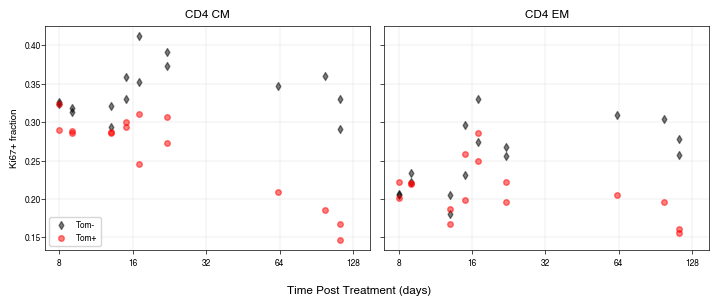

In [8]:
fig, ax =plt.subplots(1, 2, figsize=(7.2,3),sharex=True, sharey=True)



ax[0].scatter(time_index, cmtomloki67_f , color='k', marker='d', alpha=0.5, label='Tom-')
ax[0].set_xlim([7,tmax])
ax[0].set_xscale('log', base=2)
ax[0].set_title('CD4 CM')


ax[0].scatter(time_index, cmtomhiki67_f , color='r', alpha=0.5, label='Tom+')
ax[0].set_ylabel('Ki67+ fraction')
ax[0].xaxis.set_major_formatter(mticker.ScalarFormatter())
ax[0].legend(loc='lower left')



ax[1].scatter(time_index, emtomloki67_f, alpha=0.5,  color='k', marker='d',)
ax[1].set_title('CD4 EM')
ax[1].scatter(time_index, emtomhiki67_f, alpha=0.5, color='r')
ax[1].xaxis.set_major_formatter(mticker.ScalarFormatter())

fig.supxlabel('Time Post Treatment (days)')

plt.tight_layout()
fig.savefig('/home/elise/Dropbox/elisepaperclone/TCellMemory/Figures/figTomKi67.pdf', dpi='figure', format='pdf',
        bbox_inches='tight', pad_inches=0.1)
